# Machine Learning for House Price Prediction

## 1. Import Module

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from importlib import reload

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

%matplotlib inline

Import pre-define preprocessing library

In [2]:
# For train data missing value preparation
from _lib.preprocess import preprocess_missing as prep

# To get column info
from _lib.preprocess import get_instruction as info

# For test data missing value preparation
from _lib.preprocess_test import preprocess_missing as prep_test

# Function to create kaggle output
from _lib.create_output import output

## 2. Load Data

The data is located at _database/Input. We can use prep function from preprocess.py to take care of all missing values. The reasoning behind the function can be seen at EDA.ipynb

In [3]:
# Load the data
df = pd.read_csv("_database/Input/train.csv", index_col = 0)

# Preprocess missing values
df = prep(df)
# df = df.drop([1299, 935, 186, 347, 1231, 1183, 692, 955])

# Separate input and output variables
X_data = df.drop("SalePrice", axis = 1)
y = df["SalePrice"]

## 3. Polynomial Generator

We want to find the optimal model complexity, so we made a polynomial generator. This function takes a 1d or 2d numerical array and generates polynomial features for all variables

In [4]:
# Function to generate polynomial features of numerical variables
def gen_poly(data, degree):
    '''
    Input : Vector or matrix 
    
    Return matrix of polynomial for each polynomial degree from 1 to degree calculated on each column
    '''
    
    result = np.concatenate([np.power(data, d) for d in np.arange(1, degree + 1)], axis = 1)
    return result

In [5]:
# Assertion test
test_gen_poly_df = pd.DataFrame({"col1": [1,2,3], "col2": [10, 100, 1000]})
pd.DataFrame(gen_poly(test_gen_poly_df, degree=3))

,0,1,2,3,4,5
0,1,10,1,100,1,1000
1,2,100,4,10000,8,1000000
2,3,1000,9,1000000,27,1000000000


## 4. Pipeline

Now we can create pipelines for data preprocessing. First of all, we separated the features into three according to their type. Each type will be handled differently. 

In [6]:
# DataFrame of all column names with their type
df_type = pd.DataFrame({"Columns" : X_data.columns, "Type" : [str(X_data[col].dtype) for col in X_data.columns]})

# Split the columns according to their type
num_columns = df_type.loc[(df_type["Type"] == "int64") | (df_type["Type"] == "float64")]["Columns"]  # Numeric
cat_columns = df_type.loc[(df_type["Type"] == "category")]["Columns"]  # Categorical
bool_columns = df_type.loc[df_type["Type"] == "bool"]["Columns"]  # Boolean

# Categories in categorical features
list_categories = [np.array(info(col)) for col in cat_columns.values]
list_categories[14] = np.arange(1, 11)  # Change the category of column 14 and 15 to numerical
list_categories[15] = np.arange(1, 11)

The pipeline works as follows:
 1. Separate the data into three parts: numerical, categorial, and boolean
 2. Generate **Polynomial** features for numerical data based on the poly_degree argument
 3. Generate **One Hot** variables for categorical data and drop the first column (prevent multicollinearity)
 4. Combine the data

In [7]:
def poly_reg_pipeline(poly_degree):

    get_numerical = FunctionTransformer(lambda x : x[num_columns.values].values, validate = False)

    get_category = FunctionTransformer(lambda x : x[cat_columns.values], validate = False)

    get_bool = FunctionTransformer(lambda x : x[bool_columns.values].values, validate = False)

    generate_poly = FunctionTransformer(lambda x : gen_poly(x, poly_degree), validate = False)

    pipeline_num_prep = Pipeline([('selector', get_numerical),
                                  ('poly', generate_poly)])

    pipeline_cat_prep = Pipeline([('selector', get_category),
                                  ('Dummy', OneHotEncoder(drop = 'first', sparse = False,
                                                         categories = list_categories))])

    transformers = [ ('Numerical', pipeline_num_prep), ('Categorical', pipeline_cat_prep), ('Bool', get_bool) ]

    preprocess_union = FeatureUnion(transformer_list = transformers)

    pl = Pipeline([
        ('union', preprocess_union)

    ])
    
    return pl

## 5. Simple Linear Regression

For the first quick ML, we use simple Linear Regression. The degree of our polynomial will be 1. We can use this model as our baseline model to compare with another ML models

### Transform Input Variables

In [8]:
# Create pipeline of polynomial degree 1
pl = poly_reg_pipeline(1)

# Transform input variable using pipeline
X = pl.fit_transform(X_data)

# Transform output variable to log scale
y = np.log(y)

### Train Test Split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 45)

### Fit the Model

In [10]:
# Create Linear Regression model
slr = LinearRegression()

# Fit the model
slr.fit(X_train, y_train)

# Make prediction for validation data
y_pred = slr.predict(X_val)

### MSE

In [11]:
def print_mse(estimator, mse):
    print("The MSE for {} : {}".format(estimator, mse))
    return 

In [12]:
print_mse("Linear Regression", mean_squared_error(y_val, y_pred))

The MSE for Linear Regression : 0.049022804088455614


The $\text{MSE}$ formula can be given by : 

$$\text{MSE} = \frac{1}{n} \sum_{i = 1}^{n} (y_{val}^{(i)} - \hat{y}_{val}^{(i)})^{2} $$

with $n = $ length of $y_{val}$

Keep in mind that we've transformed $y \rightarrow log(y)$, so the $\text{MSE}$ can be that small.

## 6. Polynomial Regression

Next, we want to try fitting the linear regression model with polynomial degree. We use for loop to find the best polynomial degree by looking at the lowest $\text{MSE}_{val}$

In [13]:
degree_max = 20  # Max degree
seed = 450
msle_list = []
msle_train_list = []
for i in range(1, degree_max+1):
    
    # Preprocess data and generates polynomial degree i
    pl = poly_reg_pipeline(i)
    X = pl.fit_transform(X_data)
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = seed)
    
    # Fit the Linear Regression
    plr = LinearRegression()
    plr.fit(X_train, y_train)
    
    # Make prediction for training data
    y_train_pred = plr.predict(X_train)
    
    # Calculate MSE for training data
    msle_train = mean_squared_error(y_train, y_train_pred)
    msle_train_list.append(msle_train)

    # Make prediction for validation data
    y_pred = plr.predict(X_val)
    
    # Calculate MSE for validation data
    msle = mean_squared_error(y_val, y_pred)
    msle_list.append(msle)
    
    print(f"Polynomial degree {i}. Training MSE: {round(msle_train, 5)}, Validation MSE: {round(msle, 5)}")

Polynomial degree 1. Training MSE: 0.00834, Validation MSE: 0.06247
Polynomial degree 2. Training MSE: 0.00747, Validation MSE: 3.00688
Polynomial degree 3. Training MSE: 0.01027, Validation MSE: 0.02232
Polynomial degree 4. Training MSE: 0.13889, Validation MSE: 33.91677
Polynomial degree 5. Training MSE: 0.11953, Validation MSE: 0.42743
Polynomial degree 6. Training MSE: 0.17546, Validation MSE: 16.6526
Polynomial degree 7. Training MSE: 0.07228, Validation MSE: 0.06486
Polynomial degree 8. Training MSE: 0.10975, Validation MSE: 0.07866
Polynomial degree 9. Training MSE: 0.16095, Validation MSE: 0.15667
Polynomial degree 10. Training MSE: 0.31483, Validation MSE: 0.1588
Polynomial degree 11. Training MSE: 0.16109, Validation MSE: 0.1572
Polynomial degree 12. Training MSE: 0.16194, Validation MSE: 0.1572
Polynomial degree 13. Training MSE: 0.33313, Validation MSE: 0.15707
Polynomial degree 14. Training MSE: 0.3165, Validation MSE: 0.15693
Polynomial degree 15. Training MSE: 0.16313, V

The polynomial degree 3 seems to be the best result. Note that there is a high variance

### Plot MSE Result

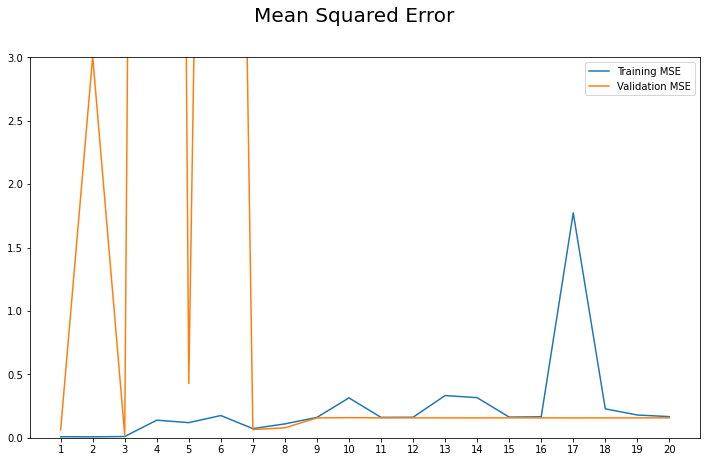

In [14]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(1, 1, figsize=(12,7))
_ = plt.plot(np.arange(1, degree_max+1), msle_train_list)
_ = plt.plot(np.arange(1, degree_max+1), msle_list)
fig.suptitle('Mean Squared Error', fontsize=20)
ax.legend(["Training MSE", "Validation MSE"])
ax.set_ylim(0, 3)
_ = plt.xticks(np.arange(1, degree_max+1, 1))

From the result, we can see that the lowest three polynomial has the best validatoin MSE.

## 7. Ridge Regression

The linear regression parameters $\theta$ can be computed by minimizing cost function $J(\theta)$ with formula :

$$J(\theta) = \frac{1}{2n} \sum_{i = 1}^{n} (\hat{y}^{(i)} - y^{(i)})^{2}$$

Ridge regression calculates $\theta$ by minimizing : 

$$J(\theta) = \frac{1}{2n} \sum_{i = 1}^{n} (\hat{y}^{(i)} - y^{(i)})^{2} + \frac{\lambda}{2n}\sum_{j = 1}^{k} \theta_{k}^{2}$$

By adding regularization term , we can reduce the value of $\theta$. This will result in a **more bias** estimator but it has a **lower variance**.

In [15]:
from sklearn.linear_model import Ridge

### Comparison of the Penalty variable

For Ridge and Lasso regression in scikit-learn, there is a regularization parameter $C$. We want to find the best $C$ for our model by comparing several values of $C$ with cross validation

In [16]:
alpha_list = np.logspace(-3, 3, 1000)

In [17]:
# Fit polynomial regression degree 1, 2, and 3
mse_list = []
for degree in range(1, 4):
    
    # Generate polynomial
    pl = poly_reg_pipeline(degree)
    X = pl.fit_transform(X_data)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 45)

    # Initialize mse array
    mse = np.zeros(len(alpha_list))
    for i in np.arange(len(alpha_list)):
        
        # Train the model
        ml = Ridge(alpha = alpha_list[i])
        ml.fit(X_train, y_train)

        # Make prediction
        y_pred = ml.predict(X_val)

        # Calculate MSE
        mse[i] = mean_squared_error(y_val, y_pred)
    
    mse_list.append(mse)

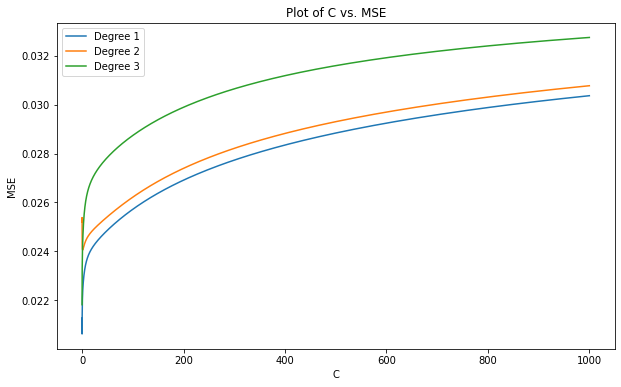

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
for i in range(3):
    ax.plot(alpha_list, mse_list[i])
ax.set_ylabel("MSE")
ax.set_xlabel("C")
ax.set_title("Plot of C vs. MSE")
plt.legend(["Degree 1", "Degree 2", "Degree 3"])

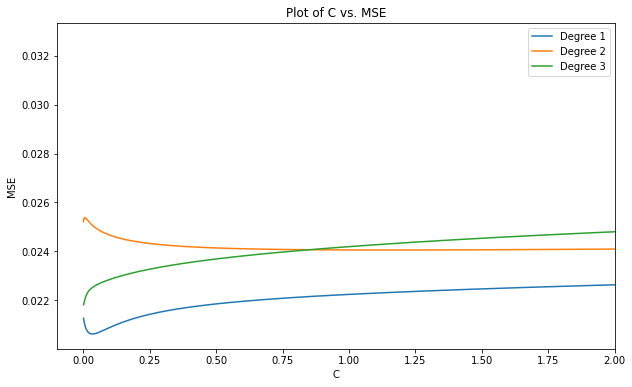

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
for i in range(3):
    ax.plot(alpha_list, mse_list[i])
ax.set_ylabel("MSE")
ax.set_xlabel("C")
ax.set_title("Plot of C vs. MSE")
ax.set_xlim(-0.1, 2)
plt.legend(["Degree 1", "Degree 2", "Degree 3"])

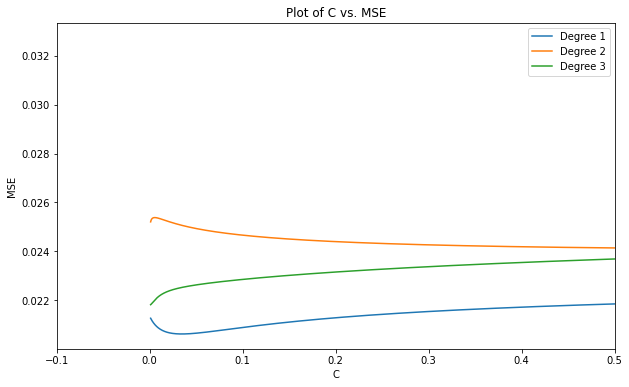

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
for i in range(3):
    ax.plot(alpha_list, mse_list[i])
ax.set_ylabel("MSE")
ax.set_xlabel("C")
ax.set_title("Plot of C vs. MSE")
ax.set_xlim(-0.1, 0.5)
plt.legend(["Degree 1", "Degree 2", "Degree 3"])

The polynomial degree 1 has the best MSE.

### Cross Validation Search

Now we know the range of penalty value, we can find the best $C$ using the function GridSearchCV

In [21]:
alpha_list = np.logspace(-3, -1, 50)
params = {'alpha' : alpha_list}

In [22]:
def fit_and_search_params(max_degree, estimator, params, verbose=False):

    # Fit polynomial regression degree
    mse = np.zeros(max_degree)
    for degree in range(1, max_degree+1):
        
        if verbose:
            print(f"Working on degree {degree}")

        # Generate polynomial
        pl = poly_reg_pipeline(degree)
        X = pl.fit_transform(X_data)

        # Split data
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 45)

        # Wrap model
        ml = estimator()
        cv = GridSearchCV(ml, param_grid = params, cv = 10)

        # Train model
        cv.fit(X_train, y_train)

        # Extract best estimator
        ml = cv.best_estimator_

        # Make prediction
        y_pred = ml.predict(X_val)

        # Calculate MSE
        mse[degree-1] = mean_squared_error(y_val, y_pred)

    
    return mse

In [23]:
max_degree = 3
mse = fit_and_search_params(max_degree, Ridge, params)
for deg in range(max_degree):
    print(f"The MSE for Ridge Regression of degree {deg+1}: {mse[deg]}")

The MSE for Ridge Regression of degree 1: 0.02089443687632767
The MSE for Ridge Regression of degree 2: 0.024664354952012503
The MSE for Ridge Regression of degree 3: 0.022857192583489477


The results are better than the linear regression, one of the reason is we have a huge number of features. Even though we didn't use polynomial, we still suffer from high variance which can be fixed by using ridge regression. Also, the best polynomial degree is still 1

## 8. Lasso Regression

Lasso regression find the parameter $\theta$ by minimizing :

$$J(\theta) = \frac{1}{2n} \sum_{i = 1}^{n} (\hat{y}^{(i)} - y^{(i)})^{2} + \frac{\lambda}{2n}\sum_{j = 1}^{k} |\theta_{k}|$$

The difference between lasso and ridge is lasso allows the parameter to be 0, so it can also perform feature selection

In [24]:
from sklearn.linear_model import Lasso

In [25]:
mse = fit_and_search_params(3, Lasso, params, verbose=True)
for deg in range(max_degree):
    print(f"The MSE for Ridge Regression of degree {deg+1}: {mse[deg]}")

Working on degree 1
Working on degree 2
Working on degree 3
The MSE for Ridge Regression of degree 1: 0.023344758001873616
The MSE for Ridge Regression of degree 2: 0.022939554696539816
The MSE for Ridge Regression of degree 3: 0.02524790779969901


The result is slightly worse than ridge regression

## 9. Decision Tree and Random Forest

We also tried using tree estimator. Decision tree is the simple tree estimator while random forest is aggregation of multiple simple decision trees

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [27]:
DecisionTreeRegressor()

DecisionTreeRegressor()

In [28]:
RandomForestRegressor()

RandomForestRegressor()

In [29]:
params_dt = {'min_samples_leaf' : np.linspace(0.1, 1, 50),
             'max_depth' : np.linspace(1, 300, 100)}

In [30]:
mse = fit_and_search_params(3, DecisionTreeRegressor, params_dt)
for deg in range(max_degree):
    print(f"The MSE for Decision Tree of polynomial degree {deg+1}: {mse[deg]}")

The MSE for Decision Tree of polynomial degree 1: 0.07034692100868473
The MSE for Decision Tree of polynomial degree 2: 0.07034692100868471
The MSE for Decision Tree of polynomial degree 3: 0.07034692100868492


The best parameter for Decision tree has higher $\text{MSE}$ than lasso

In [31]:
params_rf = {'min_samples_leaf' : np.linspace(0.0001, 0.001, 10),
         'max_depth' : np.linspace(130, 140, 5),
         'n_estimators' : np.arange(33, 39)}

In [32]:
mse = fit_and_search_params(3, RandomForestRegressor, params_rf)
for deg in range(max_degree):
    print(f"The MSE for Random Forest of polynomial degree {deg+1}: {mse[deg]}")

The MSE for Random Forest of polynomial degree 1: 0.028165399244836145
The MSE for Random Forest of polynomial degree 2: 0.027241516532797137
The MSE for Random Forest of polynomial degree 3: 0.028754921350821108


Comparing the $\text{MSE}$ of our models, we choose Ridge regression as our machine learning model to predict log house price sales since it has the lowest validation $\text{MSE}$.

## 10. Prediction

### Load Test Data

In [64]:
test = pd.read_csv("_database/Input/test.csv", index_col = 0)
test_index = test.index

### Preprocess Test Data

In [65]:
X_test = prep_test(test)

### Fit Model

In [66]:
ml = Ridge() # our choice of model

Now, we're using all of our training data to fit the model, so we need to retune the hyperparameter $C$ using all of our training data. 

In [67]:
# Generate polynomial
pl = poly_reg_pipeline(1)
X = pl.fit_transform(X_data)
X_test = pl.fit_transform(X_test)

params = {'alpha' : alpha_list} # using the alpha_list defined earlier
cv = GridSearchCV(ml, param_grid = params, cv = 10)

In [68]:
cv.fit(X, y) # using full training data

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([0.001     , 0.00109854, 0.00120679, 0.00132571, 0.00145635,
       0.00159986, 0.00175751, 0.0019307 , 0.00212095, 0.00232995,
       0.00255955, 0.00281177, 0.00308884, 0.00339322, 0.00372759,
       0.00409492, 0.00449843, 0.00494171, 0.00542868, 0.00596362,
       0.00655129, 0.00719686, 0.00790604, 0.00868511, 0.00954095,
       0.01048113, 0.01151395, 0.01264855, 0.01389495, 0.01526418,
       0.01676833, 0.0184207 , 0.0202359 , 0.02222996, 0.02442053,
       0.02682696, 0.02947052, 0.03237458, 0.0355648 , 0.0390694 ,
       0.04291934, 0.04714866, 0.05179475, 0.05689866, 0.06250552,
       0.06866488, 0.0754312 , 0.08286428, 0.09102982, 0.1       ])})

In [69]:
ml = cv.best_estimator_

In [71]:
# Since we first use log to transform y, we need to restore it using exp
y_pred = np.exp(ml.predict(X_test))

Using our module to create output, we made csv files in the output folder that contains our prediction of house prices

In [72]:
output(y_pred)

Enter a filename : results.csv
results.csv.csv was generated
